# Tutorial: Data-driven discovery of Lorenz system: Regression

#### Author: Taku Ito

7/7/2025

Reference:

Brunton, Steven L., Joshua L. Proctor, and J. Nathan Kutz. “Discovering Governing Equations from Data: Sparse Identification of Nonlinear Dynamical Systems.” PNAS (2015) https://doi.org/10.1073/pnas.1517384113.


In [2]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import tutorial_ddd
import tutorial_ddd.lorenz
%matplotlib inline
%load_ext autoreload
%autoreload 2


#### Experiment: We want to infer the governing differential equations (e.g., $\dot{x}$, $\dot{y}$, $\dot{z}$) from $x$, $y$, and $z$.
* So, we want to infer the derivatives using the linear combination of features of $x$, $y$, and $z$.
* This requires building a library of candidate nonlinear functions comprised of $x$, $y$, and $z$ (for the Lorenz) system.
* For the Lorenz system, we will simplify this library of functions to include $x$, $y$, $z$, and their second order interactions, i.e., $xx$, $xy$, $xz$, etc.

Practically, suppose we want to predict $\dot{x}$, $\dot{y}$, and $\dot{z}$. For our regression, we will fit a regression model using higher order polynomials of $x$, $y$, $z$ of up to order 2. In principle, this can be higher.

$$\dot{x} = \beta_1 x + \beta_2 y + \beta_3 z + \beta_4 x^2 + \beta_5 xy + \beta_6 xz + \beta_7 y^2 + \beta_8 yz + \beta_9 z^2 $$

We can then analyze the learned coefficients ($\beta$) to assess how well we can ''discover'' / recover the underlying governing equations

#### 2.1: Define some functions for regression

In [3]:
#### A function to create a basis set of functions for x, y, and z, and the second order interactions (e.g., xy, xx, xz, etc.) 
def create_func_library(x, y, z):
    function_library = []
    library_labels = []

    # First include the 1st order variables x, y, z
    # X 
    function_library.append(x)
    library_labels.append('x')
    # Y
    function_library.append(y)
    library_labels.append('y')
    # Z
    function_library.append(z)
    library_labels.append('z')

    #### 2nd order interactions
    # X*X
    function_library.append(x*x)
    library_labels.append('xx')
    # X*Y
    function_library.append(x*y)
    library_labels.append('xy')
    # X*Z
    function_library.append(x*z)
    library_labels.append('xz')
    # Y*Y
    function_library.append(y*y)
    library_labels.append('yy')
    # Y*Z
    function_library.append(y*z)
    library_labels.append('yz')
    # Z*Z
    function_library.append(z*z)
    library_labels.append('zz')

    function_library = np.asarray(function_library).T
    return function_library, library_labels


#### Function to implement a sequential sparse linear regression
def sparsifyRegressors(X,y,lmbda=0.01,n=10):
    """
    Define an interative sparse regression model, where certain columns of the function library are set to 0 if they are below a certain value

    X = design matrix
    y = target variables to predict
    lmbda = threshold -- any coefs lower than lmbda will be zeroed out
    n = number of sequential iterations to incrementally sparsify coefficients
    """
    Xi = X.copy()
    coef = np.linalg.inv(Xi.T @ Xi) @ Xi.T @ y
    

    # iterate n, zeroing out regressors with low coefs
    for _ in range(n):
        smallcoefs = np.abs(coef)<lmbda 
        for col in range(y.shape[1]):
            small_idx = smallcoefs[:,col]
            coef[small_idx,col] = 0
            big_idx = small_idx==False
            coef[big_idx,col] = np.linalg.inv(Xi[:,big_idx].T @ Xi[:,big_idx]) @ Xi[:,big_idx].T @ y[:,col]
    return coef


#### 2.2: Run experiment
* Simulate Lorenz time series with specified parameters
* Compute sparse regression

In [19]:
#### Define initial conditions and parameters and simulate
initial_conditions = [0.1, 0.0, 0.0]  # Starting point [x, y, z]
sigma_val = 10.0
rho_val = 28.0
beta_val = 8/3
delta_t = 0.01
total_steps = 20000 # More steps to see the chaotic attractor

print(f"Simulating Lorenz system with initial conditions: {initial_conditions}")
print(f"Parameters: sigma={sigma_val}, rho={rho_val}, beta={beta_val}")
print(f"Time step (dt): {delta_t}, Number of steps: {total_steps}")

# Simulate the system
lorenz_trajectory, derivatives = tutorial_ddd.lorenz.simulate_lorenz(
    initial_conditions,
    sigma=sigma_val,
    rho=rho_val,
    beta=beta_val,
    dt=delta_t,
    num_steps=total_steps
)

noise_amplitude = 0 # 1
noise = np.random.normal(0,noise_amplitude,lorenz_trajectory.shape)
lorenz_trajectory = lorenz_trajectory + noise


#### Compute sparse regression to discover equations models
x, y, z = lorenz_trajectory[:,0], lorenz_trajectory[:,1], lorenz_trajectory[:,2]
function_library, library_labels = create_func_library(x,y,z)

y = derivatives
X = function_library.copy()
coef = sparsifyRegressors(X,y,lmbda=0.001,n=10)

Simulating Lorenz system with initial conditions: [0.1, 0.0, 0.0]
Parameters: sigma=10.0, rho=28.0, beta=2.6666666666666665
Time step (dt): 0.01, Number of steps: 20000


#### 2.3: Visualize learned coefficients -- do the learned coefficients match the Lorenz system equations?

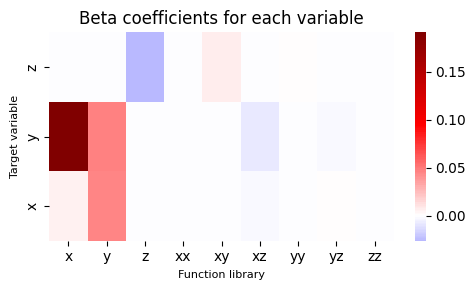

In [16]:
import seaborn as sns

plt.figure(figsize=(5,3))
ax = sns.heatmap(coef.T,center=0,cmap='seismic')
plt.title('Beta coefficients for each variable')
ax.invert_yaxis()
plt.xticks(np.arange(0.5,len(library_labels)+0.5),library_labels);
plt.xlabel('Function library',fontsize=8)
plt.yticks(np.arange(0.5,3+0.5),['x','y','z']);
plt.ylabel('Target variable',fontsize=8)
plt.tight_layout()

#### 2.4: Evaluate model fit: Compute Lorenz system using the learned regression model to simulate Lorenz system

In [17]:
def simulateEstimatedLorenz(model_coef, x0, y0, z0, num_steps=20000):
    """
    """
    trajectory = []
    trajectory.append(np.asarray([x0, y0, z0]))
    for _ in range(num_steps-1):
        basis_set, func_labels = create_func_library(trajectory[-1][0], trajectory[-1][1], trajectory[-1][2])
        dxdt = basis_set @ model_coef
        new_val = trajectory[-1] + dxdt
        trajectory.append(new_val)
    return np.asarray(trajectory)

model_trajectory = simulateEstimatedLorenz(coef, initial_conditions[0], initial_conditions[1], initial_conditions[2])

#### 2.5: Compare the original Lorenz system with the learned model from a polynomial regression

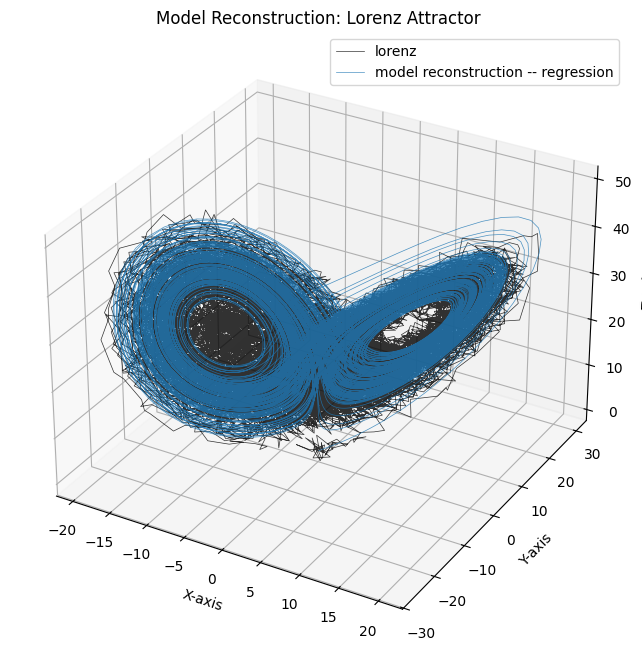

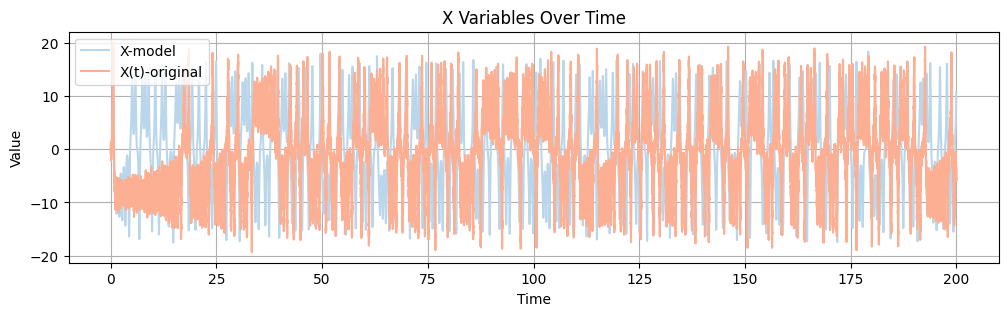

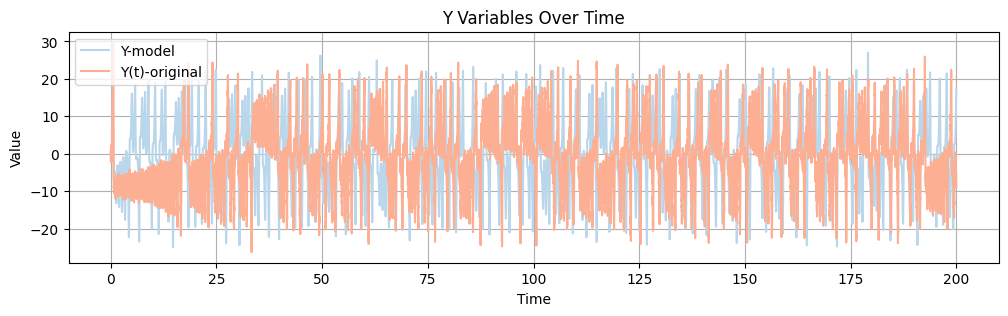

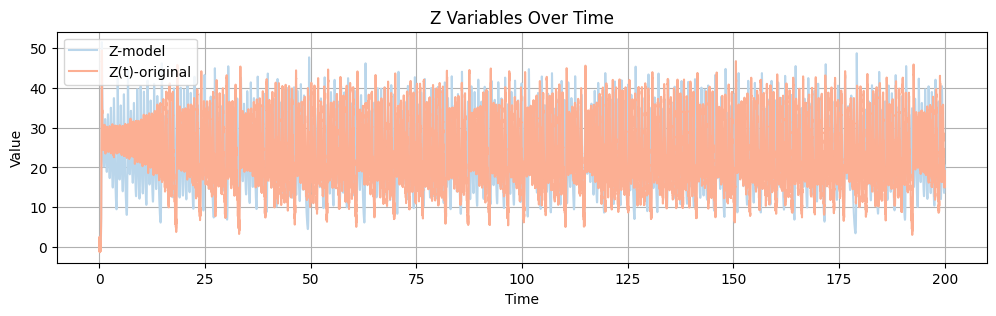

In [18]:
import seaborn as sns
# Plot the results
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(lorenz_trajectory[:, 0], lorenz_trajectory[:, 1], lorenz_trajectory[:, 2], lw=0.5, alpha=0.8, color='black', label='lorenz')
ax.plot(model_trajectory[:, 0], model_trajectory[:, 1], model_trajectory[:, 2], lw=0.5, alpha=0.8, label='model reconstruction -- regression')
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_title("Model Reconstruction: Lorenz Attractor")
plt.legend()

# You can also plot individual dimensions against time
plt.figure(figsize=(12, 3))
time_points = np.arange(0, total_steps * delta_t, delta_t)
plt.plot(time_points, model_trajectory[:, 0], label='X-model', color=sns.color_palette('Blues')[1])
plt.plot(time_points, lorenz_trajectory[:, 0], label='X(t)-original', color=sns.color_palette('Reds')[1])
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("X Variables Over Time")
plt.legend()
plt.grid(True)

plt.figure(figsize=(12, 3))
time_points = np.arange(0, total_steps * delta_t, delta_t)
plt.plot(time_points, model_trajectory[:, 1], label='Y-model', color=sns.color_palette('Blues')[1])
plt.plot(time_points, lorenz_trajectory[:, 1], label='Y(t)-original', color=sns.color_palette('Reds')[1])
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Y Variables Over Time")
plt.legend()
plt.grid(True)

plt.figure(figsize=(12, 3))
time_points = np.arange(0, total_steps * delta_t, delta_t)
plt.plot(time_points, model_trajectory[:, 2], label='Z-model', color=sns.color_palette('Blues')[1])
plt.plot(time_points, lorenz_trajectory[:, 2], label='Z(t)-original', color=sns.color_palette('Reds')[1])
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Z Variables Over Time")
plt.legend()
plt.grid(True)